This notebook aims at selecting a SBBH source for the LDC1b (Yorsh) data release.

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as un
from astropy.cosmology import z_at_value
import numpy.lib.recfunctions as recf

from ldc.common.constants.cosmology import ldc_cosmo
from ldc.io.hdf5.hdf5 import load_array
from ldc.waveform.waveform.hphc import HpHc
from ldc.common.series import TDI
# from ldc.common.series import AET2XYZ, TimeSeries, XYZ2AET
from ldc.common.tools import compute_tdi_snr, compute_tdi_snr_aet
from ldc.lisa import orbits
from ldc.lisa.noise import get_noise_model

from ldc.lisa.projection import ProjectedStrain
from ldc.common.series.timeseries import FrequencySeries, TimeSeries, TimeSeriesAccessor

from lisaconstants import ASTRONOMICAL_YEAR
from ldc.common import constants

YRSID_SI = constants.Nature.SIDEREALYEAR_J2000DAY*24*60*60


Bad key "text.kerning_factor" on line 4 in
/home/philippe/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
/usr/lib/python3.8/typing.py:898: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


We load the data as produced by the souce_selection step of the LDC pipeline (see Snakefile). With the catalogue provided by Stas it consists in 12 sources each one described defined by 14 parameters.

In [2]:
# load SBBH catalog provided by SB.
dir_cat = "/home/philippe/Desktop/data/raw_catalog_sbbh/"
name_cat = "cat-sobbh-yorsh.dat"
catalog = dir_cat+name_cat

dtype = [
    ('Mass1', '<f8'), ('Mass2', '<f8'), 
    ('Chi1', '<f8'), ('Chi2', '<f8'), ('Dist', '<f8'), 
    ('Inclination', '<f8'), ('RA', '<f8'), ('Dec', '<f8'),
    ('Phi', '<f8'), ('Lambda', '<f8'), ('Beta', '<f8'), 
    ('Psi', '<f8'), ('fstart', '<f8'), ('tc', '<f8'),
]
dat = np.genfromtxt(catalog, skip_header=1, dtype=dtype)

In [3]:
# general parameters
dt = 5 # s
t_max = 0.1 * ASTRONOMICAL_YEAR

nsources = dat.size
obs_duration = t_max * np.ones(nsources)
cadence = dt * np.ones(nsources)

In [4]:
# extract quantities from catalog
beta = dat['Beta']
lam = dat['Lambda']
phi0 = dat['Phi']
mass1 = dat['Mass1']
mass2 = dat['Mass2']

dist = dat['Dist']
z = np.array([ 
    z_at_value(ldc_cosmo.luminosity_distance, d * un.Mpc, zmin=0) for d in dist 
])

chi1 = dat['Chi1']
chi2 = dat['Chi2']
incl = dat['Inclination']
psi = dat['Psi']
f0 = dat['fstart']

theta1 = theta2 = 0
spin1 = chi1 * np.cos(theta1)
spin2 = chi2 * np.cos(theta2)

# filter with m1 < m2 condition and inverse
sindex = mass1 < mass2 # switch index
mass1[sindex], mass2[sindex] = mass2[sindex], mass1[sindex]
phi0[sindex] += np.pi
chi1[sindex], chi2[sindex] = chi2[sindex], chi1[sindex]
spin1[sindex], spin2[sindex] = spin2[sindex], spin1[sindex]

params = [
    beta,
    lam,
    mass1,
    mass2,
    spin1,
    spin2,
    incl,
    f0,
    phi0,
    psi,
    z,
    dist
]
names = [
    'EclipticLatitude',
    'EclipticLongitude',
    'Mass1',
    'Mass2',
    'Spin1',
    'Spin2',
    'Inclination',
    'InitialFrequency',
    'InitialPhase',
    'Polarization',
    'Redshift',
    'Distance'
]
cat = np.rec.fromarrays(
    params, names=names
)

cat = recf.append_fields(cat, ['ObservationDuration', 'Cadence'],
                       [obs_duration, cadence],
                       usemask=False)

In [5]:
# load SBBH catalogue
# path_cat = "/home/philippe/Desktop/run2/sbbh.h5"
# cat = load_array(path_cat)

# names = [
#     'EclipticLatitude',
#     'EclipticLongitude',
#     'Mass1',
#     'Mass2',
#     'Spin1',
#     'Spin2',
#     'Inclination',
#     'InitialFrequency',
#     'InitialPhase',
#     'Polarization',
#     'Redshift',
#     'Distance',
#     'ObservationDuration',
#     'Cadence'
# ]

In [6]:
nsources = len(cat[1])
nparams = len(names)+2
print(f"Catalogue contains {nsources} sources")
print(f"Each source has {nparams} parameters")
print(cat)

Catalogue contains 14 sources
Each source has 14 parameters
[(3.27362513,  1.14746112, 67.60123751, 54.60689712, -0.27364811,  0.01199896, 0.50802155, 0.01105104, 0., 5.76519177, 0.05022937, 232.84526827, 3155814.97635456, 5.)
 (2.83007519, -0.10035773, 97.66678599, 95.21437344, -0.00124472,  0.11413909, 2.17693632, 0.00759428, 0., 4.79689411, 0.08179641, 387.53968491, 3155814.97635456, 5.)
 (0.13566138,  0.46209434, 36.01838581, 28.44367941,  0.25236236,  0.12334831, 3.0515994 , 0.01608975, 0., 4.44737664, 0.02520628, 114.76025787, 3155814.97635456, 5.)
 (3.58806139, -0.50776569, 75.87217442, 70.09751516,  0.02094657,  0.02571015, 0.41440342, 0.00828172, 0., 4.26962086, 0.05072941, 235.24638527, 3155814.97635456, 5.)
 (5.37020681,  0.35245963, 83.70292345, 70.57789301,  0.03925805, -0.05138942, 0.41422342, 0.00810142, 0., 5.06143628, 0.07151641, 336.47336263, 3155814.97635456, 5.)
 (5.97041892, -1.56497404, 88.63005897, 77.4674161 ,  0.1194916 ,  0.07214722, 2.10679912, 0.00798278, 0.

We first start by generating the waveforms corresponding with the above parameters then store them in a dictionnary.

In [7]:
# generate FD waveforms
def gen_waveforms(cat, names):
    SOBHB = HpHc.type("my-sobhb", "SBBH", "IMRPhenomD")
    params = cat #[0]
    dict_waveforms = {}
    for n, param in enumerate(params):
        
        # Extract infos
        print(f"processing {n+1}th waveform...")
        dict_params = dict(zip(names, param))
        dict_params['Cadence'] = dt
        dict_params['ObservationDuration'] = t_max
        print(f"waveform parameters: {dict_params}")
        
        # Generate & store waveforms
        hp_s,hc_s = SOBHB.compute_hphc_fd(dict_params)
        dict_waveforms[n] = (hp_s.f, hp_s, hc_s)
        # f, _, _ = SOBHB.SOBHB_IMRPhenomD_waveform()
        # dict_waveforms[n] = (f, hp_s, hc_s)
        
        break
        
    return dict_waveforms

In [8]:
d_fd_wvfs = gen_waveforms(cat, names)

processing 1th waveform...
waveform parameters: {'EclipticLatitude': 3.2736251291176677, 'EclipticLongitude': 1.1474611190561297, 'Mass1': 67.6012375061373, 'Mass2': 54.60689712327767, 'Spin1': -0.27364811099291725, 'Spin2': 0.011998964232965016, 'Inclination': 0.5080215462153057, 'InitialFrequency': 0.011051042189314747, 'InitialPhase': 0.0, 'Polarization': 5.765191772980243, 'Redshift': 0.0502293693755069, 'Distance': 232.84526826690532, 'Cadence': 5, 'ObservationDuration': 3155814.97635456}


We plot the frequency domain waveforms. They look strange, especially for what concerns the frequency range.

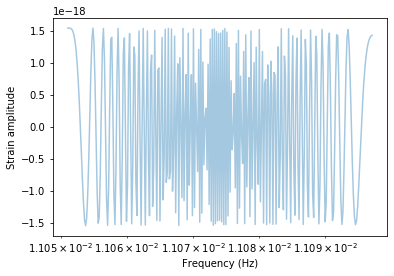

In [9]:
# plot FD waveforms
a, b = 0, 1000

fig = plt.figure()
for n in range(len(cat[0])):
    f, hp, hc = d_fd_wvfs[n]
    plt.plot(f[a:b], np.real(hp)[a:b], alpha=0.4, label="plus")
    # plt.plot(f, np.real(hc), alpha=0.4, label="cross")
    
    break

plt.xscale("log")
# plt.yscale("log")
# plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain amplitude")
plt.show()

We compute the TDI then the SNR for each waveform. Indeed all routines that compute the SNR start from TDI.

In [10]:
def custom_SNR(f,A,E,T,SA,ST) :
    SN2 = 4.0*(f[1]-f[0])*np.sum((A.real**2+A.imag**2 + E.real**2+E.imag**2)/SA+(T.real**2+T.imag**2)/ST)
    return np.sqrt(SN2)

def window(tm, show=False):
    xl = 1000
    ind_r = np.argwhere(tm[-1]-tm <= xl)[0][0]
    xr = tm[ind_r]
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    if show:
        plt.plot(tm, winl)
        plt.plot(tm, winr)
        plt.grid(True)
        plt.show()
    return (winl*winr)

4.539786870244589e-05 1.0


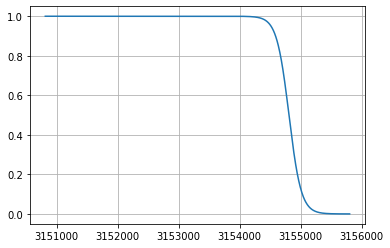

In [11]:
# plot window
t = np.arange(0, t_max, dt)
w = window(t)
print(np.min(w), np.max(w))

# a, b = 0, 1000
a, b = len(t)-1000, len(t)-1
fig = plt.figure()
plt.plot(t[a:b], w[a:b])
plt.grid()

In [15]:
from ldc.common.tools.snr import compute_tdi_snr_xyz, compute_tdi_snr_aet

tdi2=False
params = cat
    
approximant = "IMRPhenomD"
duration = t_max
dt = cat['Cadence'][0]
print(f"Duration: {duration}")
print(f"dt: {dt}")

lisa_orbits = orbits.Orbits.type(
    dict({"nominal_arm_length":2.5e9*un.m,
          "initial_rotation":0*un.rad,
          "initial_position":0*un.rad,
          "orbit_type":"analytic"})
)

hphc = HpHc.type("demo", "SBBH", approximant)
P = ProjectedStrain(lisa_orbits)
trange = np.arange(0, duration, dt)

jitter_amp = 0.05        
idx_src = 0 #np.random.randint(nsrcs)
base_params = params[idx_src]

# extract params
print("===============================")
dict_params = dict(zip(names, base_params))
dict_params['Cadence'] = dt
dict_params['ObservationDuration'] = duration

# add jitter
dict_params['Mass1'] *= 1 + np.random.normal(0, jitter_amp)
dict_params['Mass2'] *= 1 + np.random.normal(0, jitter_amp)
dict_params['Spin1'] *= 1 + np.random.normal(0, jitter_amp)
dict_params['Spin2'] *= 1 + np.random.normal(0, jitter_amp)
dict_params['InitialFrequency'] *= 1 + np.random.normal(0, jitter_amp)

# Move source closer and compute associated redshift.
dict_params['Distance'] *= 1 - np.abs(np.random.normal(0, jitter_amp))
dict_params['Redshift'] = z_at_value(
        ldc_cosmo.luminosity_distance, 
        dict_params['Distance'] * un.Mpc, 
        zmin=0
)
        
print(f"waveform parameters: {dict_params}")

hphc.set_param(dict_params)
P.arm_response(0, duration, dt, [hphc])

X_ = TimeSeries(P.compute_tdi_x(trange, tdi2=tdi2), dt=dt)
Y_ = TimeSeries(P.compute_tdi_y(trange, tdi2=tdi2), dt=dt)
Z_ = TimeSeries(P.compute_tdi_z(trange, tdi2=tdi2), dt=dt)
X = TimeSeriesAccessor(X_).fft(win=window)
Y = TimeSeriesAccessor(Y_).fft(win=window)
Z = TimeSeriesAccessor(Z_).fft(win=window)
# X = FrequencySeries(P.compute_tdi_x(trange, tdi2=tdi2), df=1/duration)
# Y = FrequencySeries(P.compute_tdi_y(trange, tdi2=tdi2), df=1/duration)
# Z = FrequencySeries(P.compute_tdi_z(trange, tdi2=tdi2), df=1/duration)
tdi = TDI(dict(zip(["X", "Y", "Z"], [X, Y, Z])))

# compute SNR LDC from TDI XYZ
fmin, fmax = X.f[0], X.f[-1]
print(fmin, fmax)
N_ldc = get_noise_model("SciRDv1", X.f)
psd = N_ldc.psd(X.f, option='X', tdi2=tdi2)
dict_snr = compute_tdi_snr(tdi, N_ldc, AET=False, full_output=True)
# dict_snr = compute_tdi_snr_xyz(tdi, N_ldc, tdi, fmin, fmax, tdi2=tdi2, full_output=True)
snr = np.sqrt(dict_snr["tot2"])
print(f"> SNR[LDC XYZ]={snr}")
        
#         # convert to AET
#         tdi.XYZ2AET()
#         A = tdi["A"]

#         # compute SNR LDC from TDI AET
#         fmin, fmax = A.f[0], A.f[-1]
#         N_ldc = get_noise_model("SciRDv1", A.f)
#         # psd = N_ldc.psd(A.f, option='A', tdi2=tdi2)
#         dict_snr = compute_tdi_snr(tdi, N_ldc, AET=True, full_output=True)
#         # dict_snr = compute_tdi_snr_aet(tdi, N_ldc, tdi, fmin, fmax, tdi2=tdi2, full_output=True)
#         snr = np.sqrt(dict_snr["tot2"])
#         print(f"> SNR[LDC AET]={snr}")

#         # compute SNR custom        
#         A, E, T = tdi["A"], tdi["E"], tdi["T"]

#         SA = N_ldc.psd(A.f, option='A', tdi2=tdi2)
#         ST = N_ldc.psd(T.f, option='T', tdi2=tdi2)
#         snr_sb = custom_SNR(A.f, A, E, T, SA, ST)
#         print(f"> SNR[custom]={snr_sb}")

Duration: 3155814.97635456
dt: 5.0
waveform parameters: {'EclipticLatitude': 3.2736251291176677, 'EclipticLongitude': 1.1474611190561297, 'Mass1': 69.3261040879469, 'Mass2': 52.823324480201606, 'Spin1': -0.3040510037636386, 'Spin2': 0.01296750178994113, 'Inclination': 0.5080215462153057, 'InitialFrequency': 0.010005659124180293, 'InitialPhase': 0.0, 'Polarization': 5.765191772980243, 'Redshift': 0.04811395762303327, 'Distance': 222.7051381064485, 'Cadence': 5.0, 'ObservationDuration': 3155814.97635456}
<xarray.DataArray 'f' ()>
array(0.)
Coordinates:
    f        float64 0.0
Attributes:
    units:    1/s <xarray.DataArray 'f' ()>
array(0.19999968)
Coordinates:
    f        float64 0.2
Attributes:
    units:    1/s
> SNR[LDC XYZ]=157.186369546221


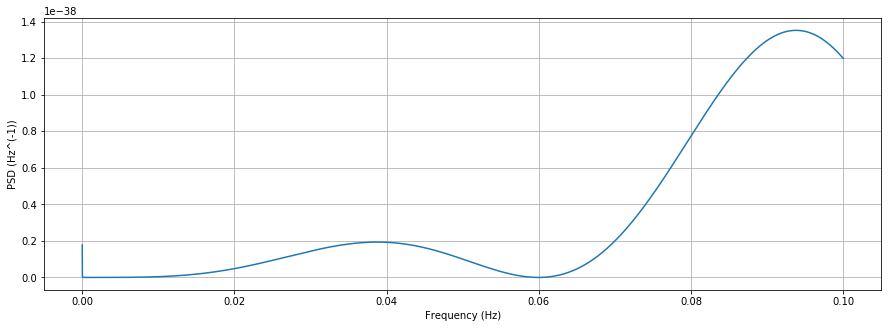

In [13]:
# plot psd
k = 20

fig = plt.figure(figsize=(15,5))

plt.plot(X.f[k:], psd[k:])
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (Hz^(-1))")
plt.grid()

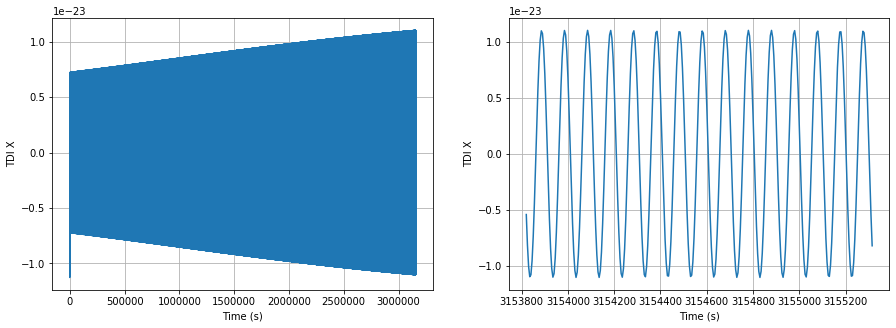

In [16]:
# plot TDI X
N = len(X)
# a, b = 29000, 29400
# a, b = 0, N-1
a, b = N-400, N-100
t = np.linspace(0, t_max, len(X))

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(t, np.real(X))
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("TDI X")
ax[0].grid()

ax[1].plot(t[a:b], np.real(X)[a:b])
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("TDI X")
ax[1].grid()